# Capstone Project - The Battle of the Neighborhoods

# Applied Data Science Capstone by IBM/Coursera¶

# Table of contents

1. <a href="#item1">Introduction: Business Problem</a>
2. <a href="#item2"> Data</a>
3. <a href="#item3"> Methodology</a>
4. <a href="#item4"> Analysis</a>
5. <a href="#item5"> Results and Discussion</a>
6. <a href="#item6"> Conclusion</a>

# Introduction: Business Problem 

In this project, we are trying to find a solution to the stakeholders that want to open a Turkish Restaurant in Amsterdam.

Since there are lots of parameters to find a best place to open a Turkish Restaurant, we can use data science techniques to handle with this problem.

Especially important facts that must be considered are;

-How many restaurants are in a special neighbourhood?
-What type of restaurants are there?
-Is a neighbourhood special or not with people’s culture who lives there? (For example there can be a lot of Turkish restaurants in the neighbourhood 
 where mostly Turkish people live)

# Data 

We will use;

-Pgeocode api to get the coordinates of the neighbourhoods in Amsterdam.
-Foursquare api to get the venues in Amsterdam.

Let's import libraries

In [1]:
!pip install pgeocode
!pip install folium

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
    100% |████████████████████████████████| 92kB 12.1MB/s ta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [4]:
import numpy as np
import pandas as pd
import requests
import sys
from geopy.geocoders import Nominatim
import collections
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import radians, sin, cos, acos
import pgeocode
import folium

# Example for how pgeocode works

As you can see below, pgeocode gives us the coordinates of neighbourhouds according to their postal codes.

In [5]:
nomi = pgeocode.Nominatim('nl')
nomi.query_postal_code("1012")

postal_code                1012
country code                 NL
place_name            Amsterdam
state_name        Noord-Holland
state_code                    7
county_name           Amsterdam
county_code                 363
community_name              NaN
community_code              NaN
latitude                52.3735
longitude                4.8951
accuracy                      6
Name: 0, dtype: object

In [6]:
postal_code = [1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1031, 1032, 1033, 1034, 
               1035, 1036, 1037, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 
               1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1081, 1082, 1083, 1086, 
               1087, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109]

In [7]:
len(postal_code)

81

Let's create an empty dataframe to put the coordinates of neighbourhoods.

In [8]:
d = {'postal_code': [], 'latitude': [],'longitude': []}
df = pd.DataFrame(data=d)
df.head()

,latitude,longitude,postal_code


In [9]:
for i in postal_code:
    i = str(i)
    lat = nomi.query_postal_code(i)['latitude']
    long = nomi.query_postal_code(i)['longitude']
    df = df.append({'postal_code': i, 'latitude': lat,'longitude': long}, ignore_index=True)    
    
df.head()

,latitude,longitude,postal_code
0,52.3710,4.9041,1011
1,52.3735,4.8951,1012
2,52.3877,4.8840,1013
3,52.3913,4.8683,1014
4,52.3784,4.8836,1015


Now, we are ready to fetch data from foursquare API.

# Foursquare

In [10]:
CLIENT_ID = 'ZVWA0TV0WWZF1RU2SWTY50ZD1RTQE4C2AGH0ZDSCMDSZRKDW'# your Foursquare ID
CLIENT_SECRET = 'E0LUZQOI3UXXOJ22E0YRI1GTONTQUBWU10XU2GYGGUXBRUBB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZVWA0TV0WWZF1RU2SWTY50ZD1RTQE4C2AGH0ZDSCMDSZRKDW
CLIENT_SECRET:E0LUZQOI3UXXOJ22E0YRI1GTONTQUBWU10XU2GYGGUXBRUBB



Function to get the venues nearby the neighbourhood

In [11]:
LIMIT = 100
radius = 250

def getNearbyVenues(postal_code,latitudes, longitudes, radius=500):
    
    venues_list=[]
    for post, lat, lng in zip(postal_code, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            post,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['postal_code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
amsterdam_venues = getNearbyVenues(df['postal_code'],df['latitude'],df['longitude'])

In [13]:
amsterdam_venues.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1011,52.371,4.9041,Black Gold,52.371787,4.903056,Record Shop
1,1011,52.371,4.9041,HPS,52.371683,4.907673,Cocktail Bar
2,1011,52.371,4.9041,De Sluyswacht,52.369777,4.901516,Bar
3,1011,52.371,4.9041,Restaurant Gebr. Hartering,52.371577,4.907455,Restaurant
4,1011,52.371,4.9041,Gassan Diamonds HQ,52.369519,4.903789,Jewelry Store


We have 2604 venues in Amsterdam

In [14]:
amsterdam_venues.shape

(2604, 7)

Let's look at our venues in Amsterdam.

In [15]:
amsterdam_venues['Venue Category'].value_counts()

Bar                              120
Coffee Shop                      103
Restaurant                       101
Café                              92
Hotel                             88
Italian Restaurant                80
Supermarket                       74
Bakery                            73
Plaza                             38
Pizza Place                       37
Bus Stop                          37
Snack Place                       37
Sandwich Place                    34
French Restaurant                 33
Park                              32
Tram Station                      32
Grocery Store                     31
Chinese Restaurant                30
Burger Joint                      28
Gym / Fitness Center              28
Breakfast Spot                    28
Vegetarian / Vegan Restaurant     27
Ice Cream Shop                    27
Asian Restaurant                  27
Gym                               26
Thai Restaurant                   25
Turkish Restaurant                24
Y

Using folium library, I can visualize venues on the map. But firstly I need the coordinates of Amsterdam to center it on the map.

In [16]:
geolocator = Nominatim(user_agent='myapplication')
location = geolocator.geocode("Amsterdam")
amsterdam_center = [location.latitude,location.longitude]
print('Coordinates of Amsterdam is {} N {} S'.format(amsterdam_center[0],amsterdam_center[1]))

Coordinates of Amsterdam is 52.3745403 N 4.89797550561798 S


In [17]:
map_amsterdam = folium.Map(location=amsterdam_center, zoom_start=13)
folium.Marker(amsterdam_center, popup='Amsterdam').add_to(map_amsterdam)
for lat, lon in zip(amsterdam_venues['Venue Latitude'], amsterdam_venues['Venue Longitude']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=1, color='blue', fill=False).add_to(map_amsterdam)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_amsterdam

# Methodology 
In our case, Stakeholders are looking for a place to open a Turkish Restaurant. So we take only the restaurants into consideration.

In the first step, we will create a new dataframe that contains only restaurants. Then we determine the frequencies of restaurants. According to that, we implement k-means clustering to understand data better. Clustering shows us the specific neighbourhoods with specific restaurants.

After clustering, we will decide where to open a Turkish Restaurant according to some parameters like restaurant density of the neighbourhood, distance from Amsterdam Center etc.

# Analysis 

Let's look at the restaurant types.

In [18]:
rest_types = []
for i in amsterdam_venues['Venue Category']:
    if 'Restaurant' in i:
        if i not in rest_types:
            rest_types.append(i)

There are lots of restaurants types but one important point is that there are some restaurants without any specific category such as 'Middle Eastern', 'Swiss'.

In [19]:
rest_types

['Restaurant',
 'Mediterranean Restaurant',
 'Swiss Restaurant',
 'Thai Restaurant',
 'Chinese Restaurant',
 'Malay Restaurant',
 'Mexican Restaurant',
 'Sushi Restaurant',
 'Italian Restaurant',
 'African Restaurant',
 'South American Restaurant',
 'Japanese Restaurant',
 'Asian Restaurant',
 'French Restaurant',
 'Argentinian Restaurant',
 'Ramen Restaurant',
 'Indian Restaurant',
 'Seafood Restaurant',
 'Tapas Restaurant',
 'Dutch Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Turkish Restaurant',
 'Indonesian Restaurant',
 'Spanish Restaurant',
 'Comfort Food Restaurant',
 'Afghan Restaurant',
 'Greek Restaurant',
 'Latin American Restaurant',
 'Modern European Restaurant',
 'Caribbean Restaurant',
 'Vietnamese Restaurant',
 'Fast Food Restaurant',
 'Doner Restaurant',
 'Persian Restaurant',
 'Korean Restaurant',
 'Empanada Restaurant',
 'Peruvian Restaurant',
 'Moroccan Restaurant',
 'Tibetan Restaurant',
 'Middle Eastern Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restauran

First of all, I am creating an empty dataframe with the same columns to gather all restaurant into a single dataframe.

In [20]:
rest_df = pd.DataFrame(columns = amsterdam_venues.columns)
rest_df

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [21]:
for i in rest_types:
    df2 = amsterdam_venues[amsterdam_venues['Venue Category']==i]
    rest_df = rest_df.append(df2)
rest_df.reset_index(drop=True,inplace =True)
rest_df.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1011,52.3710,4.9041,Restaurant Gebr. Hartering,52.371577,4.907455,Restaurant
1,1012,52.3735,4.8951,The Lobby,52.371159,4.893661,Restaurant
2,1013,52.3877,4.8840,Worst,52.388963,4.887593,Restaurant
3,1013,52.3877,4.8840,BAK restaurant,52.390432,4.887080,Restaurant
4,1013,52.3877,4.8840,Walvis,52.389032,4.879820,Restaurant


Now, I can see that there are only 633 restaurants out of 2611 venues.

In [22]:
rest_df.shape

(619, 7)

Let's explore the frequencies of restaurant types.

In [23]:
grouped = rest_df.groupby(['Venue Category']).count()
grouped.sort_values('postal_code', ascending=False,inplace = True)
grouped.head(10)

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Restaurant,101,101,101,101,101,101
Italian Restaurant,80,80,80,80,80,80
French Restaurant,33,33,33,33,33,33
Chinese Restaurant,30,30,30,30,30,30
Vegetarian / Vegan Restaurant,27,27,27,27,27,27
Asian Restaurant,27,27,27,27,27,27
Thai Restaurant,25,25,25,25,25,25
Turkish Restaurant,24,24,24,24,24,24
Seafood Restaurant,19,19,19,19,19,19


We will use top ten frequent restaurant types for clustering.

In [24]:
top_ten_rest = grouped.index[:10]
top_ten_rest.name = ''

In [25]:
top_ten_rest

Index(['Restaurant', 'Italian Restaurant', 'French Restaurant',
       'Chinese Restaurant', 'Vegetarian / Vegan Restaurant',
       'Asian Restaurant', 'Thai Restaurant', 'Turkish Restaurant',
       'Seafood Restaurant', 'Fast Food Restaurant'],
      dtype='object', name='')

Now let's cluster the neighbourhoods in Amsterdam using top ten restaurant types.

First of all, I should create a new dataframe, with columns of ten different restaurant types and rows of neighbourhoods.

In [26]:
df_cluster = pd.DataFrame(columns = top_ten_rest)
df_cluster

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant


In this dataframe, I want to see how many restaurants are in a specific area by looking the row of that area.

In [27]:
for post in rest_df['postal_code'].unique():
    df_post = rest_df[rest_df['postal_code']== post]
    att = []
    for cat in top_ten_rest:
        att.append(np.sum(df_post['Venue Category'] == cat))
    df_cluster.loc[post] = att

In [28]:
df_cluster.head()

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant
1011,1,4,0,4,0,0,4,0,0,0
1012,1,1,2,2,0,2,1,0,1,0
1013,6,0,2,0,1,0,0,1,0,0
1014,2,0,0,0,0,0,0,0,0,0
1015,1,6,0,1,0,0,2,0,3,0


As you can see below, Total number of each restaurant types are equal to the total number in the previous dataframe.

In [29]:
df_cluster.sum(axis=0)


Restaurant                       101.0
Italian Restaurant                80.0
French Restaurant                 33.0
Chinese Restaurant                30.0
Vegetarian / Vegan Restaurant     27.0
Asian Restaurant                  27.0
Thai Restaurant                   25.0
Turkish Restaurant                24.0
Seafood Restaurant                19.0
Fast Food Restaurant              18.0
dtype: float64

Now, Our dataset is ready for any machine learning algorithm. We will implement k-means clustering to see the different types of neighbourhoods. At first, We should find the best k for my model.

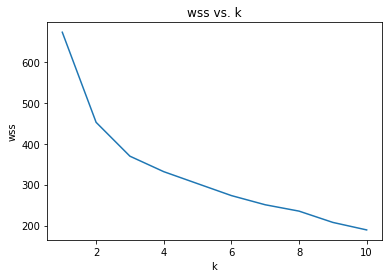

In [30]:
wss = [] # within sum of clusters
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster.values)
    wss.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1,11),wss)
plt.title('wss vs. k')
plt.ylabel('wss')
plt.xlabel('k')
plt.show()

As you can see, k = 6 is the elbow point in the graph. Then we will select k equals 6.

In [31]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_cluster.values)

Let's add the cluster lables to our dataset.

In [32]:
df_cluster['cluster_class'] = kmeans.labels_
df_cluster.head()

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant,cluster_class
1011,1,4,0,4,0,0,4,0,0,0,5
1012,1,1,2,2,0,2,1,0,1,0,0
1013,6,0,2,0,1,0,0,1,0,0,3
1014,2,0,0,0,0,0,0,0,0,0,2
1015,1,6,0,1,0,0,2,0,3,0,5


When we look at the total number of neighbourhoods in each cluster, Cluster 0 is the most frequent cluster as you can see below.

In [33]:
df_cluster.groupby(['cluster_class']).count()

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant
cluster_class,,,,,,,,,,
0,35,35,35,35,35,35,35,35,35,35
1,8,8,8,8,8,8,8,8,8,8
2,13,13,13,13,13,13,13,13,13,13
3,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
5,3,3,3,3,3,3,3,3,3,3


Let's write a function to summarize all clusters.

In [34]:
def cluster_summary(k):
    for i in range(k):
        print('----------Cluster Summary {}-----------'.format(str(i)))
        print(df_cluster[df_cluster['cluster_class']==i].mean())
        total = df_cluster[df_cluster['cluster_class']==i].sum().sum()
        neigh = len(df_cluster[df_cluster['cluster_class']==i])
        avg = total/neigh
        print('Average restaurants for the cluster :', avg)
        print('Total number of neighbourhoods in the cluster:', neigh)

In [35]:
cluster_summary(6)

----------Cluster Summary 0-----------

Restaurant                       0.457143
Italian Restaurant               0.371429
French Restaurant                0.114286
Chinese Restaurant               0.514286
Vegetarian / Vegan Restaurant    0.057143
Asian Restaurant                 0.285714
Thai Restaurant                  0.114286
Turkish Restaurant               0.428571
Seafood Restaurant               0.171429
Fast Food Restaurant             0.400000
cluster_class                    0.000000
dtype: float64
Average restaurants for the cluster : 2.91428571429
Total number of neighbourhoods in the cluster: 35
----------Cluster Summary 1-----------

Restaurant                       1.250
Italian Restaurant               2.375
French Restaurant                0.375
Chinese Restaurant               0.000
Vegetarian / Vegan Restaurant    1.250
Asian Restaurant                 1.125
Thai Restaurant                  0.750
Turkish Restaurant               0.500
Seafood Restaurant           

As you can see from the summary,

-While cluster 0 is so common, there is not many restaurants in that areas. So we can think that we don't suggest these neighbourhoods to the stakeholders.

-Cluster 1 has more average restaurants than cluster 0. But it is really low when we compare with other clusters.

-Cluster 2 has the highest average number of Turkish Restaurants. So, maybe these neighbourhoods are places where Turkish people live.

-Cluster 3 has more restaurants than Cluster 2. But there are a lot of restaurants without any specific category. So, this cluster needs more research.

-Even though cluster 4 has a lot of restaurants, it has a huge number of Italian Restaurants. I can assume that the people lives in those areas really like Italian cuisine. 
 So opening a Turkish restaurant in these neighbourhoods may not be a good idea.
 
-When we look at the cluster 5, it can be seen that there are many asian restaurants. So the same situation exists like cluster 4.

In [36]:
df_cluster.sort_index(inplace=True)


In the plot below, we can see that there are 5 Turkish Restaurants in neighbourhood with '1063' postal code. There can be many Turkish people living.

At first, opening a Turkish restaurant in a Turkish Borough sounds logical but there are still a lot of Turkish Restaurants. So If we open a Turkish restaurant there, we must share the market and this is not wanted by stakeholders. Also you can see below that there are only Turkish restaurants in 1063.

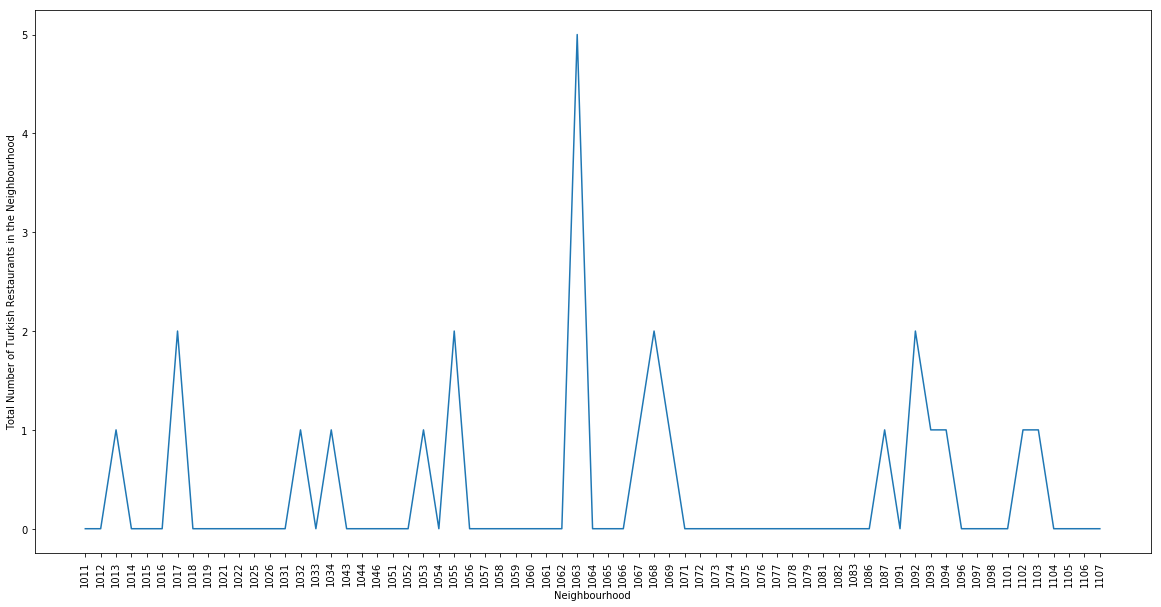

In [37]:
plt.figure(figsize = (20,10))
plt.plot(df_cluster['Turkish Restaurant'])
plt.ylabel('Total Number of Turkish Restaurants in the Neighbourhood')
plt.xlabel('Neighbourhood')
plt.xticks(rotation='vertical')
plt.show()

In [38]:
df_cluster.loc['1063',:]


Restaurant                       0
Italian Restaurant               0
French Restaurant                0
Chinese Restaurant               0
Vegetarian / Vegan Restaurant    0
Asian Restaurant                 0
Thai Restaurant                  0
Turkish Restaurant               5
Seafood Restaurant               0
Fast Food Restaurant             2
cluster_class                    0
Name: 1063, dtype: object

To better understand the clustering, let's visualize it with folium map.

First, we need coordinates again.

In [39]:
for i in df_cluster.index:
    df_cluster.loc[i,'latitude'] = nomi.query_postal_code(i)['latitude']
    df_cluster.loc[i,'longitude'] = nomi.query_postal_code(i)['longitude']
df_cluster.head()

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant,cluster_class,latitude,longitude
1011,1,4,0,4,0,0,4,0,0,0,5,52.3710,4.9041
1012,1,1,2,2,0,2,1,0,1,0,0,52.3735,4.8951
1013,6,0,2,0,1,0,0,1,0,0,3,52.3877,4.8840
1014,2,0,0,0,0,0,0,0,0,0,2,52.3913,4.8683
1015,1,6,0,1,0,0,2,0,3,0,5,52.3784,4.8836


In [40]:
map_clustering = folium.Map(location=amsterdam_center, zoom_start=13)
for post in df_cluster.index:
    lat = df_cluster.loc[post,'latitude']
    lon = df_cluster.loc[post,'longitude']
    #folium.Marker([lat,lon], popup=post).add_to(map_clustering)
    if df_cluster.loc[post,'cluster_class'] == 0:
        folium.Circle([lat, lon], radius=1, color='red', fill=False).add_to(map_clustering) # Very little restaurants
    elif df_cluster.loc[post,'cluster_class'] == 1:
        folium.Circle([lat, lon], radius=1, color='green', fill=False).add_to(map_clustering)  # Less amount of restaurants  
    elif df_cluster.loc[post,'cluster_class'] == 2:
        folium.Circle([lat, lon], radius=1, color='yellow', fill=False).add_to(map_clustering) # Average distribution
    elif df_cluster.loc[post,'cluster_class'] == 3:
        folium.Circle([lat, lon], radius=1, color='blue', fill=False).add_to(map_clustering)   # Restaurants     
    elif df_cluster.loc[post,'cluster_class'] == 4:
        folium.Circle([lat, lon], radius=1, color='purple', fill=False).add_to(map_clustering) # Italian Restaurants  
    else:
        folium.Circle([lat, lon], radius=1, color='pink', fill=False).add_to(map_clustering) # Japanese Restaurants

folium.Marker(amsterdam_center, popup='Amsterdam').add_to(map_clustering)
    
map_clustering

Red points belongs to Cluster 0. It is not suprising that while these neighbourhoods are very far away from the city center, they have leest number of restaurants.

We should focus on Cluster 2 and Cluster 3. Because they are closer to the city center and have a lot of Restaurants.

In [41]:
df_filter = df_cluster[(df_cluster.cluster_class == 2) | (df_cluster.cluster_class ==  3)]

We have totally 11 neighbourhoods that needs to be taken in to consideration.

In [42]:
df_filter.shape

(17, 13)

In [43]:
df_filter

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant,cluster_class,latitude,longitude
1013,6,0,2,0,1,0,0,1,0,0,3,52.3877,4.8840
1014,2,0,0,0,0,0,0,0,0,0,2,52.3913,4.8683
1016,5,3,3,0,0,0,2,0,1,0,3,52.3709,4.8816
1018,2,1,1,0,0,0,0,0,0,0,2,52.3675,4.9180
1031,2,1,0,0,0,0,0,0,0,0,2,52.3886,4.9068
1032,2,0,0,0,0,0,1,1,0,1,2,52.3964,4.9127
1043,2,1,0,0,0,0,0,0,0,0,2,52.3886,4.8332
1056,2,1,1,0,0,0,0,0,0,0,2,52.3732,4.8559
1057,6,0,1,1,0,0,0,0,0,0,3,52.3677,4.8551
1058,4,1,2,0,1,0,0,0,0,0,2,52.3579,4.8510


Let's look at distance of these neighbourhoods from Amsterdam city center.

In [44]:
def discal():
    slat = radians(amsterdam_center[0])
    slon = radians(amsterdam_center[1])
    for i in df_filter.index:
        elat = radians(df_filter.loc[i,'latitude'])
        elon = radians(df_filter.loc[i,'longitude'])
        df_filter.loc[i,'dist_from_Ams'] = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))

In [45]:
discal()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
df_filter

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant,cluster_class,latitude,longitude,dist_from_Ams
1013,6,0,2,0,1,0,0,1,0,0,3,52.3877,4.8840,1.743854
1014,2,0,0,0,0,0,0,0,0,0,2,52.3913,4.8683,2.744024
1016,5,3,3,0,0,0,2,0,1,0,3,52.3709,4.8816,1.183087
1018,2,1,1,0,0,0,0,0,0,0,2,52.3675,4.9180,1.568749
1031,2,1,0,0,0,0,0,0,0,0,2,52.3886,4.9068,1.674176
1032,2,0,0,0,0,0,1,1,0,1,2,52.3964,4.9127,2.628096
1043,2,1,0,0,0,0,0,0,0,0,2,52.3886,4.8332,4.666228
1056,2,1,1,0,0,0,0,0,0,0,2,52.3732,4.8559,2.860195
1057,6,0,1,1,0,0,0,0,0,0,3,52.3677,4.8551,3.008533
1058,4,1,2,0,1,0,0,0,0,0,2,52.3579,4.8510,3.687356


Stakeholders wants to be close to city center. We can filter our neighbourhoods with 2 km distance metric from city center.

In [47]:
df_son = df_filter[df_filter.dist_from_Ams<2]

In [48]:
df_son

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant,cluster_class,latitude,longitude,dist_from_Ams
1013,6,0,2,0,1,0,0,1,0,0,3,52.3877,4.8840,1.743854
1016,5,3,3,0,0,0,2,0,1,0,3,52.3709,4.8816,1.183087
1018,2,1,1,0,0,0,0,0,0,0,2,52.3675,4.9180,1.568749
1031,2,1,0,0,0,0,0,0,0,0,2,52.3886,4.9068,1.674176


At the end, we have 3 neighbourhoods that are close and have many restaurants. Let's visualize it again with folium map.

In [49]:
map_filter = folium.Map(location=amsterdam_center, zoom_start=13)
for post in df_son.index:
    lat = df_son.loc[post,'latitude']
    lon = df_son.loc[post,'longitude']
    folium.Marker([lat, lon], popup=post).add_to(map_filter)
    
folium.Marker(amsterdam_center, popup='Amsterdam').add_to(map_filter)
    
map_filter

Let's look at the total number of restaurants in our last 3 neighbourhoods.

In [50]:
col_list= list(df_son)

col_list = [e for e in col_list if e not in ('cluster_class',
 'latitude',
 'longitude',
 'dist_from_Ams')]

In [51]:
col_list

['Restaurant',
 'Italian Restaurant',
 'French Restaurant',
 'Chinese Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Asian Restaurant',
 'Thai Restaurant',
 'Turkish Restaurant',
 'Seafood Restaurant',
 'Fast Food Restaurant']

In [52]:
df_son['sum'] = df_son[col_list].sum(axis=1)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [53]:
df_son

,Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Thai Restaurant,Turkish Restaurant,Seafood Restaurant,Fast Food Restaurant,cluster_class,latitude,longitude,dist_from_Ams,sum
1013,6,0,2,0,1,0,0,1,0,0,3,52.3877,4.8840,1.743854,10.0
1016,5,3,3,0,0,0,2,0,1,0,3,52.3709,4.8816,1.183087,14.0
1018,2,1,1,0,0,0,0,0,0,0,2,52.3675,4.9180,1.568749,4.0
1031,2,1,0,0,0,0,0,0,0,0,2,52.3886,4.9068,1.674176,3.0


As you can see, Neighbourhood with '1016' postal code, has the highest number of restaurants in our last 3 neighbourhoods. Let's take a closer look at our neighbourhood.

In [54]:
selected_area = df[df.postal_code == '1016'].reset_index(drop=True)

In [55]:
selected_area

,latitude,longitude,postal_code
0,52.3709,4.8816,1016


We define slat and slon variables for folium map.

In [57]:
slat = selected_area.loc[0]['latitude']
slon = selected_area.loc[0]['longitude']

Let's get the venues in this neighbourhood again.

In [58]:
selected_area_venues = getNearbyVenues('1016',selected_area['latitude'],selected_area['longitude'])

In [59]:
selected_area_venues.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,52.3709,4.8816,Chocolatl,52.370608,4.879963,Chocolate Shop
1,1,52.3709,4.8816,De Nieuwe Yogaschool,52.371581,4.878668,Yoga Studio
2,1,52.3709,4.8816,Mendo,52.370383,4.883755,Bookstore
3,1,52.3709,4.8816,Tromp Kaashuis,52.369841,4.881327,Cheese Shop
4,1,52.3709,4.8816,IJscuypje / Stamppotje,52.370405,4.882402,Ice Cream Shop


Filter our venues with restaurants.

In [60]:
sa_rest_df = pd.DataFrame(columns = amsterdam_venues.columns)
sa_rest_df

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [61]:
for i in rest_types:
    df2 = selected_area_venues[selected_area_venues['Venue Category']==i]
    sa_rest_df = sa_rest_df.append(df2)
sa_rest_df.reset_index(drop=True,inplace =True)
sa_rest_df.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,52.3709,4.8816,Venus & Adonis,52.371056,4.882462,Restaurant
1,1,52.3709,4.8816,Divan,52.370079,4.882055,Restaurant
2,1,52.3709,4.8816,Bluespoon,52.367848,4.882861,Restaurant
3,1,52.3709,4.8816,Brasserie OCCO,52.369216,4.883679,Restaurant
4,1,52.3709,4.8816,'t Zwaantje,52.370392,4.883819,Restaurant


There are 19 restaurants in our neighbourhood.

In [62]:
sa_rest_df.shape

(18, 7)

Let's visualize our restaurants in our new folium map.

In [64]:
map_1016 = folium.Map(location=(slat,slon), zoom_start=16)
for i in range(18):
    lat = sa_rest_df.iloc[i,4]
    lon = sa_rest_df.iloc[i,5]
    if sa_rest_df.iloc[i,6] == 'Restaurant':
        folium.Circle([lat, lon], radius=1, color='red', fill=False).add_to(map_1016) # Restaurant
    elif sa_rest_df.iloc[i,6] == 'Thai Restaurant':
        folium.Circle([lat, lon], radius=1, color='green', fill=False).add_to(map_1016)  # Thai Restaurant  
    elif sa_rest_df.iloc[i,6] == 'Italian Restaurant':
        folium.Circle([lat, lon], radius=1, color='yellow', fill=False).add_to(map_1016) # Italian Restaurant
    elif sa_rest_df.iloc[i,6] == 'French Restaurant':
        folium.Circle([lat, lon], radius=1, color='blue', fill=False).add_to(map_1016)   # French Restaurant    
    else:
        folium.Circle([lat, lon], radius=1, color='pink', fill=False).add_to(map_1016) # Other Types of Restaurants
folium.Marker((slat,slon), popup='1016').add_to(map_1016)
    
map_1016

The intersection of Elandsgracht street and Prinsengracht street is an attraction center for restaurants and people. And also there are 4 restaurants that we don't know their exact category. It is a good place to open a Turkish Restaurant but it still needs more research like;

What are the demographic informations of the people who lives there?
What are the exact category of these 4 restaurants?
Do the people like Turkish food there?
Is the market is big enough to withstand another restaurant?


# Results and Discussion 

Our analysis shows that neighbourhood with 1016 postal code is the best place according to our data. Following results are written below:

Even though there are 81 neighbourhoods across Amsterdam, many of them have a small number of restaurants. We think that it is because of the attraction of city center. So we focused on neighbourhoods that are closer to city center.
Also there is a neighbourhood with 5 Turkish Restaurants, we don't prefer to open another Turkish restaurant there. We assume that it is a place where mostly Turkish people live. Despite it looks good to open a Turkish Restaurant in a place where mostly Turkish people live, the market is shared by only 5 Turkish restaurants.
Italian restaurants are very popular in Amsterdam thanks to the Italian Cuisine.
In addition to these results, there are also missing points to lighten for opening a Turkish Restaurant.

What are the rental costs for restaurants compared with the market in that region?
Is there any good place to rent in these neighbourhoods for a restaurant?
Why are specific types of restaurants so common in some neighbourhoods? What are the exact reason? In this project, we only assumed some of these reasons.

# Conclusion 

In this project, we try to find the best place for a Turkish Restaurant according to foursquare venue data. We try to understand the characteristics of neighbourhoods by looking the venues in these places. There are some neighbourhoods with mostly one specific type of restaurants. Then, we turned our focus to neighbourhoods that have different kinds of restaurants. When the distance from the city center and the total number of restaurants of the neighbourhoods is taken into consideration, Neighbourhood with 1016 postal code is the best place to open a Turkish Restaurant.

During this project, we come to a point but it still needs more research to decide the optimal place for a Turkish Restaurant.